In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Dense, Bidirectional, LSTM
from keras.models import Model
from keras.callbacks import EarlyStopping

import numpy as np

In [2]:
coin_dataframes = {}

def convert_comma_int(field):
    try:
        return int(field.replace(',', ''))
    except ValueError:
        return None
    
df = pd.read_csv("./bitcoin_cash_price.csv", parse_dates=["Date"])
df['Market Cap'] = df['Market Cap'].map(convert_comma_int)

coin_dataframes["bitcoin"] = df.sort_values('Date')

In [3]:
coin_dataframes.keys()

dict_keys(['bitcoin'])

In [4]:
coin_dataframes["bitcoin"].head()

,Date,Open,High,Low,Close,Volume,Market Cap
212,2017-07-23,555.89,578.97,411.78,413.06,"85,013",NaN
211,2017-07-24,412.58,578.89,409.21,440.70,"190,952",NaN
210,2017-07-25,441.35,541.66,338.09,406.90,"524,908",NaN
209,2017-07-26,407.08,486.16,321.79,365.82,"1,784,640",NaN
208,2017-07-27,417.10,460.97,367.78,385.48,"533,207",NaN


<Figure size 2000x800 with 0 Axes>

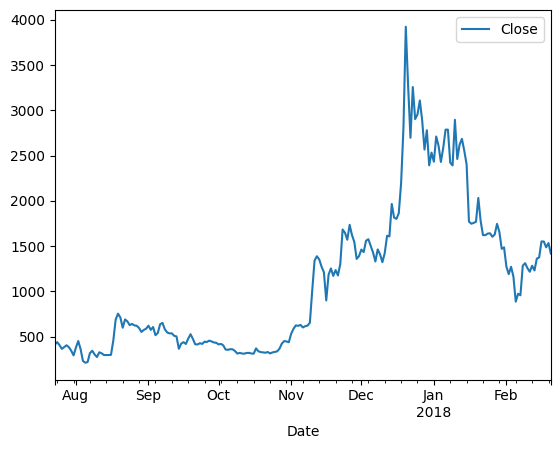

In [5]:
plt.figure(figsize=(20,8))
coin_dataframes['bitcoin'].plot(x='Date', y='Close')
plt.show()

In [6]:
def add_relative_columns(df):
    day_diff = df['Close'] - df['Open']
    df['rel_close'] = day_diff / df['Open']
    df['high_low_ratio'] = df['High'] / df['Low']
    df['rel_high'] = df['High'] / df['Close']
    df['rel_low'] = df['Low'] / df['Close']
    
    
for df in coin_dataframes.values():
    add_relative_columns(df)
    
coin_dataframes["bitcoin"].head()

,Date,Open,High,Low,Close,Volume,Market Cap,rel_close,high_low_ratio,rel_high,rel_low
212,2017-07-23,555.89,578.97,411.78,413.06,"85,013",NaN,-0.256939,1.406018,1.401661,0.996901
211,2017-07-24,412.58,578.89,409.21,440.70,"190,952",NaN,0.068156,1.414653,1.313569,0.928545
210,2017-07-25,441.35,541.66,338.09,406.90,"524,908",NaN,-0.078056,1.602118,1.331187,0.830892
209,2017-07-26,407.08,486.16,321.79,365.82,"1,784,640",NaN,-0.101356,1.510799,1.328960,0.879640
208,2017-07-27,417.10,460.97,367.78,385.48,"533,207",NaN,-0.075809,1.253385,1.195834,0.954083


In [7]:
def create_history_frames(coin_dataframes):
    history_frames = {}
    for coin_name, df in coin_dataframes.items():
        history_frames[coin_name], x_cols = create_history_frame(df)
    return history_frames, x_cols
        

def create_history_frame(df):
    feature_cols = ['rel_close', 'rel_high', 'rel_low', 'high_low_ratio']
    y_col = ['rel_close']
    x_cols = []
    days = 10
    history = df[['Date'] + y_col].copy()
    for n in range(1, days+1):
        for feat_col in feature_cols:
            colname = '{}_{}'.format(feat_col, n)
            history[colname] = df[feat_col].shift(n)
            x_cols.append(colname)
    history = history[days:]
    return history, x_cols

y_col = 'rel_close'
coin_history, x_cols = create_history_frames(coin_dataframes)

In [8]:
def create_model():
    input_layer = Input(batch_shape=(None, len(x_cols), 1))

    layer = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
    layer = Bidirectional(LSTM(128))(layer)

    out = Dense(1, activation="sigmoid")(layer)

    m = Model(inputs=input_layer, outputs=out)
    m.compile("rmsprop", loss='mean_squared_error')

    return m

def create_train_test_mtx(history):
    X = history[x_cols].values
    y = history[y_col].values

    X = X.reshape(X.shape[0], X.shape[1], 1)

    rand_mtx = np.random.permutation(X.shape[0])

    train_split = int(X.shape[0] * 0.9)
    train_indices = rand_mtx[:train_split]

    test_indices = rand_mtx[train_split:]

    X_train = X[train_indices]
    X_test = X[test_indices]

    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

def train_model(model, X, y):
    ea = EarlyStopping(monitor='val_loss', patience=2)
    val_loss = model.fit(X, y, epochs=20, batch_size=32, verbose=1, validation_split=.1)
    return val_loss

In [9]:
rmse = {}
pred = {}
test = {}

for coin_name, history in coin_history.items():
    model = create_model()
    X_train, X_test, y_train, y_test = create_train_test_mtx(history)
    train_model(model, X_train, y_train)
    test[coin_name] = y_test
    
    pred[coin_name] = model.predict(X_test)
    rmse[coin_name] = np.sqrt(np.mean((pred[coin_name] - y_test)**2))

    print(coin_name, rmse[coin_name])

Epoch 1/20
6/6 [==============================] - 11s 507ms/step - loss: 0.0806 - val_loss: 0.0286
Epoch 2/20
6/6 [==============================] - 1s 122ms/step - loss: 0.0155 - val_loss: 0.0289
Epoch 3/20
6/6 [==============================] - 1s 123ms/step - loss: 0.0153 - val_loss: 0.0291
Epoch 4/20
6/6 [==============================] - 1s 133ms/step - loss: 0.0153 - val_loss: 0.0291
Epoch 5/20
6/6 [==============================] - 1s 146ms/step - loss: 0.0153 - val_loss: 0.0292
Epoch 6/20
6/6 [==============================] - 1s 128ms/step - loss: 0.0153 - val_loss: 0.0296
Epoch 7/20
6/6 [==============================] - 1s 153ms/step - loss: 0.0153 - val_loss: 0.0297
Epoch 8/20
6/6 [==============================] - 1s 127ms/step - loss: 0.0153 - val_loss: 0.0299
Epoch 9/20
6/6 [==============================] - 1s 146ms/step - loss: 0.0153 - val_loss: 0.0297
Epoch 10/20
6/6 [==============================] - 1s 136ms/step - loss: 0.0153 - val_loss: 0.0298
Epoch 11/20
6/6 [=

In [10]:
pred_sign = {coin_name: np.sign(pred[coin_name]) * np.sign(test[coin_name]) for coin_name in pred.keys()}
for coin, val in sorted(pred_sign.items()):
    cnt = np.unique(pred_sign[coin], return_counts=True)[1]
    print("[{}] pos/neg change guessed correctly: {}, incorrectly: {}, correct%: {}".format(
        coin, cnt[0], cnt[1], cnt[0]/ (cnt[0]+cnt[1]) * 100))

[bitcoin] pos/neg change guessed correctly: 336, incorrectly: 105, correct%: 76.19047619047619
